In [1]:
# Import tensorflow and configure GPUs
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
print("Num of GPUS available: " + str(len(gpus)))
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass
strategy = tf.distribute.MirroredStrategy()

Num of GPUS available: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [2]:
# Import other libraries needed for the neural network
!pip install scikit-learn pandas plotly seaborn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import display
import plotly.express as px

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from tensorflow import test
import random

# Set the seeds
np.random.seed(1337)
set_seed(1337)
random.seed(1337)

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Data Preparation

In [3]:
age_gender_data = pd.read_csv("data/age_gender.csv")
age_gender_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [4]:
age_gender_data.head()

age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...  
3  193 197 198 200 199 200 202 203 204 205 208 21...  
4  202 205 209 210 209 209 210 211 212 214 218 21...

<AxesSubplot:xlabel='age', ylabel='count'>

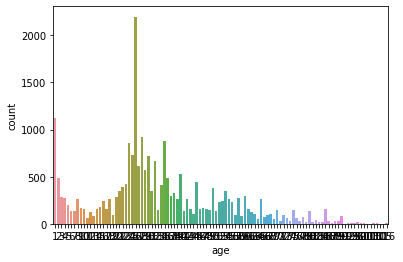

In [5]:
sns.countplot(x="age", data=age_gender_data)

<AxesSubplot:xlabel='gender', ylabel='count'>

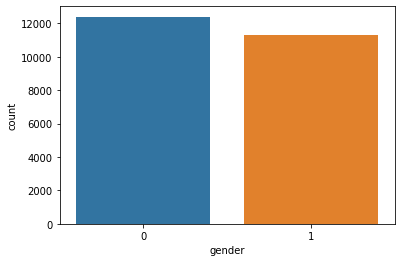

In [6]:
# Gender Distribution
sns.countplot(x="gender", data=age_gender_data)

## Data Preprocessing

<AxesSubplot:xlabel='age', ylabel='count'>

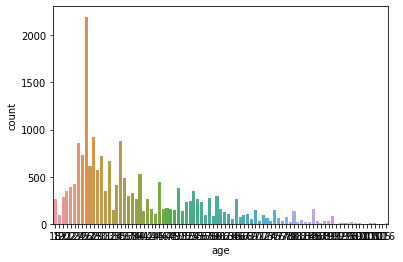

In [7]:
# Select people who are above 18 years old
age_gender_data = age_gender_data[age_gender_data["age"] >= 18]
sns.countplot(x="age", data=age_gender_data)

In [8]:
age_gender_data.reset_index(drop=True, inplace=True)
age_gender_data

age  ethnicity  gender                        img_name  \
0      100          0       0  20170112213500903.jpg.chip.jpg   
1      100          0       0  20170112215240346.jpg.chip.jpg   
2      100          0       1  20170110183726390.jpg.chip.jpg   
3      100          0       1  20170112213001988.jpg.chip.jpg   
4      100          0       1  20170112213303693.jpg.chip.jpg   
...    ...        ...     ...                             ...   
19467   99          0       1  20170120221920654.jpg.chip.jpg   
19468   99          1       1  20170120134639935.jpg.chip.jpg   
19469   99          2       1  20170110182418864.jpg.chip.jpg   
19470   99          2       1  20170117195405372.jpg.chip.jpg   
19471   99          0       1  20170110182052119.jpg.chip.jpg   

                                                  pixels  
0      203 185 139 163 176 184 186 175 175 156 159 13...  
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...  
2      235 164 113 144 121 201 243 237 234 221 233 23...  
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...  
4      70 72 94 149 154 166 175 169 172 161 176 187 2...  
...                                                  ...  
19467  127 100 94 81 77 77 74 99 102 98 128 145 160 1...  
19468  23 28 32 35 42 47 68 85 98 103 113 117 130 129...  
19469  59 50 37 40 34 19 30 101 156 170 177 184 187 1...  
19470  45 108 120 156 206 197 140 180 191 199 204 207...  
19471  156 161 160 165 170 173 166 177 183 191 187 18...  

[19472 rows x 5 columns]

In [9]:
# Check how many null values we have
age_gender_data.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [10]:
# Input image configuration
num_pixels = len(age_gender_data["pixels"][0].split(' '))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension

print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))

Pixels: 2304
Width: 48, Height: 48


In [11]:
# Splitting dataset into X and y
X_img = age_gender_data.iloc[:,4].copy()
y_age = age_gender_data.iloc[:,0].copy()
y_ethnicity = age_gender_data.iloc[:,1].copy()
y_gender = age_gender_data.iloc[:,2].copy()

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_img, y_gender, test_size=0.3, random_state=1337)
# Splitting the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.15, random_state=1337)

def str_to_npArr(x):
    '''
    Function to convert pixel data (string) into numpy_array of pixels
    '''
    x = x.reset_index(drop=True)
    x = x.apply(lambda x: np.array(x.split(), dtype="float32")) # Converting data into numpy array
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])

# Converting the string of pixels into image array for each of train, validation, and test set and normalization
X_train = str_to_npArr(X_train)
X_test = str_to_npArr(X_test)
X_val = str_to_npArr(X_val)

print("Target: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>")
print("Current: shape = {}, type = {}".format(X_train.shape, type(X_train)))

Target: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>
Current: shape = (13630, 48, 48, 1), type = <class 'numpy.ndarray'>


In [12]:
target_columns = ['gender', 'ethnicity', 'age']

age_gender_data_preprocess = age_gender_data.drop('img_name', axis=1)
y = age_gender_data_preprocess[target_columns]
X = age_gender_data_preprocess.drop(target_columns, axis=1)

print(X)
print("--------------------------------------------------------")
print(y)

                                                  pixels
0      203 185 139 163 176 184 186 175 175 156 159 13...
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2      235 164 113 144 121 201 243 237 234 221 233 23...
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4      70 72 94 149 154 166 175 169 172 161 176 187 2...
...                                                  ...
19467  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470  45 108 120 156 206 197 140 180 191 199 204 207...
19471  156 161 160 165 170 173 166 177 183 191 187 18...

[19472 rows x 1 columns]
--------------------------------------------------------
       gender  ethnicity  age
0           0          0  100
1           0          0  100
2           1          0  100
3           1          0  100
4           1          0  100
...       ...        ...  ...
19467       1          

In [13]:
X = X['pixels'].apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
X = np.array(X)/255.0 # normalization
X = np.array([ X[i].reshape(48,48,1) for i in range(X.shape[0]) ])

print("Target: X Shape: {}".format(X.shape))
print("Current: X Shape: {}".format(X.shape))

Target: X Shape: (19472, 48, 48, 1)
Current: X Shape: (19472, 48, 48, 1)


In [14]:
y_gender = np.array(y['gender'])
y_ethnicity = np.array(y['ethnicity'])
y_age = np.array(y['age'])

## Data Visualization

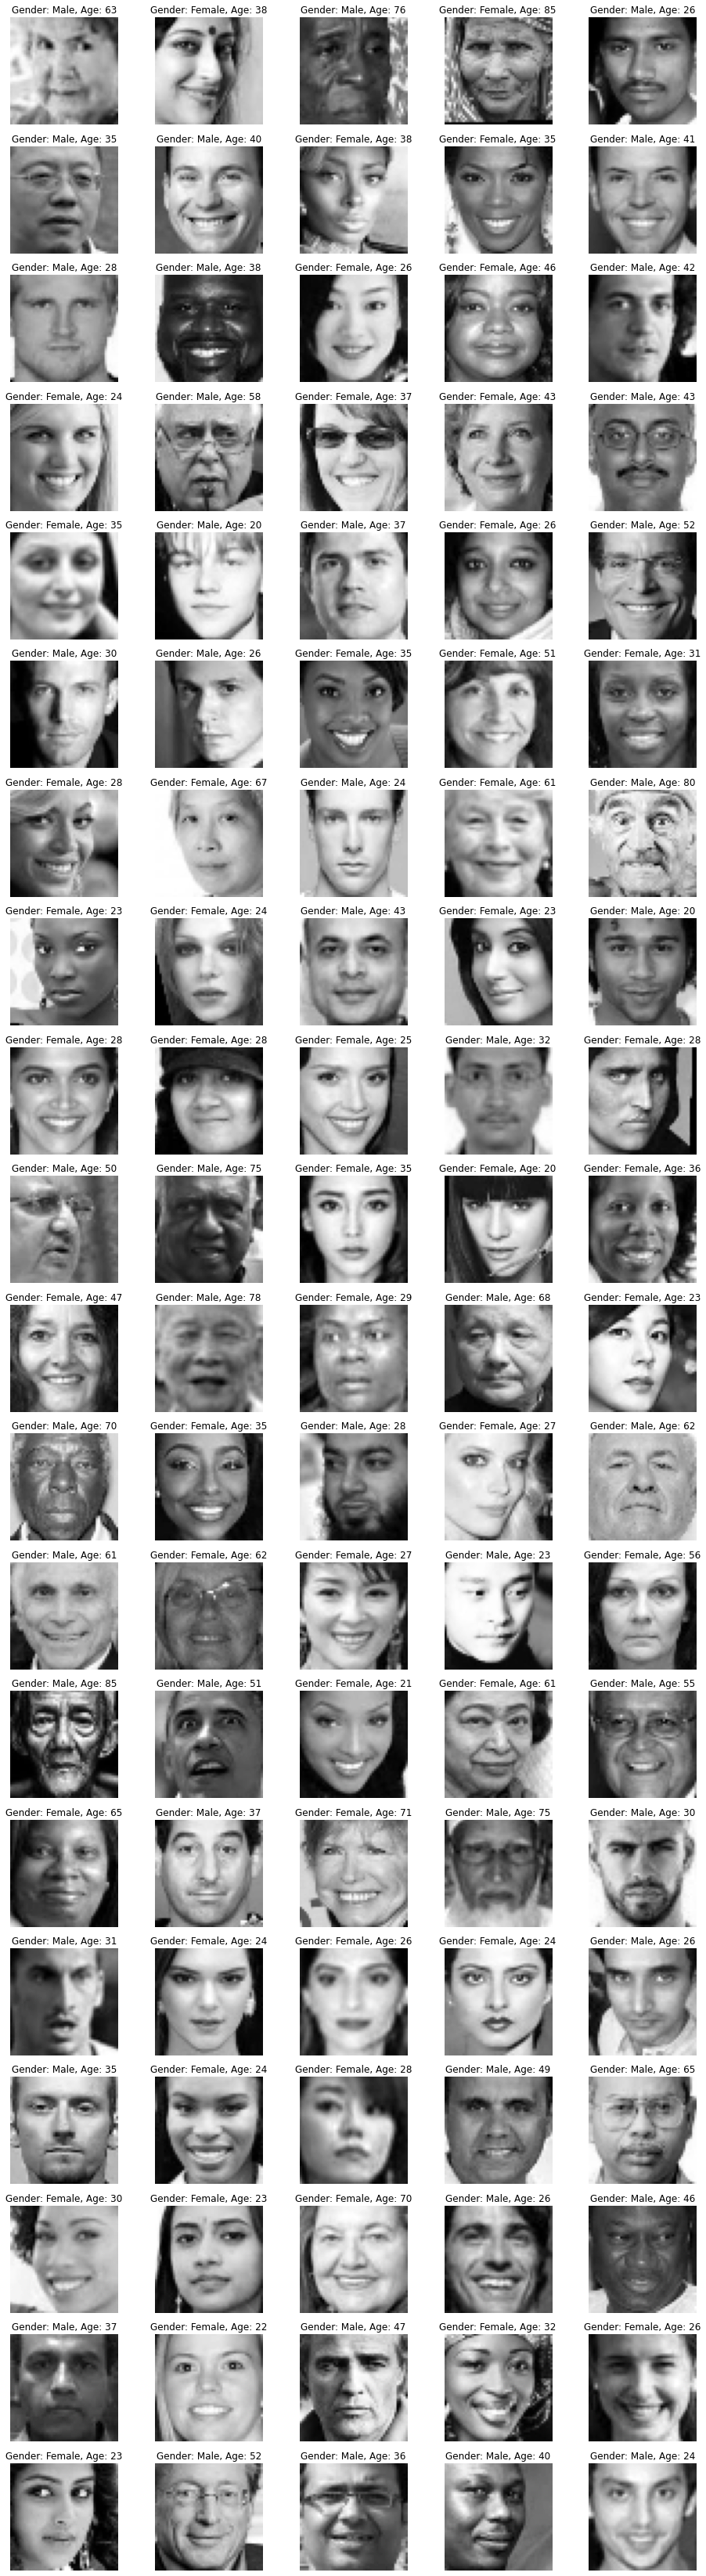

In [15]:
rows = 20
cols = 5
samp = random.sample(range(X.shape[0]), rows*cols) # Select 100 random examples
x_samp = X[samp, :, :, :]
y_samp_gender = y_gender[samp]
y_samp_age = y_age[samp]

fig,ax = plt.subplots(rows,cols,figsize=(16,60))
r = 0
c = 0

for i in range(rows * cols):
    aa = x_samp[i, :, :, :].reshape(48, 48)
    ax[r, c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    ax[r,c].set_title(f"Gender: {'Female' if y_samp_gender[i]==1 else 'Male'}, Age: {y_samp_age[i]}")
    c += 1
    if c == cols:
        c = 0
        r += 1
plt.show()

## Image Augmentation

In [16]:
train_data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=1,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.8, 1.2],
    rescale=1/255
)

val_data_gen = ImageDataGenerator(rescale=1/255)
test_data_gen = ImageDataGenerator(rescale=1/255)

In [22]:
val_data = val_data_gen.flow(X_val, y_val, seed=1337, shuffle=False)
test_data = test_data_gen.flow(X_test, y_test, seed=1337, shuffle=False)

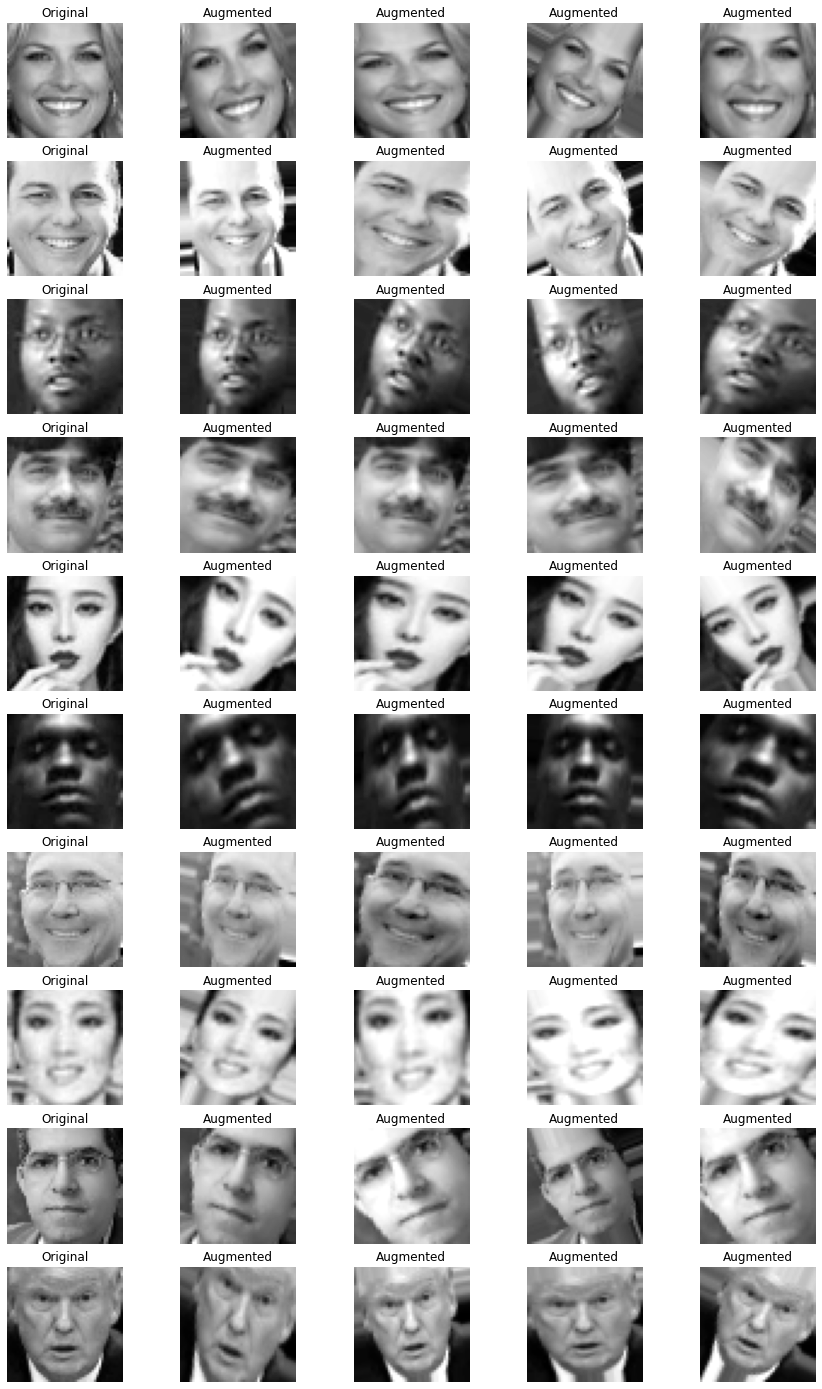

In [17]:
fig,ax = plt.subplots(10,5,figsize=(15,25))
for n in range(10):    
    r = random.sample(range(X.shape[0]),1)[0]
    ax[n,0].imshow(X[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

## Training

In [18]:
# Model configuration
batch_size = 32
img_width, img_height, img_num_channels = 48, 48, 1
loss_function = sparse_categorical_crossentropy
no_classes = 20
no_epochs = 50
optimizer = Adam()
verbosity = 1
num_folds = 10
activation = "softmax"

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)
input_shape

(48, 48, 1)

In [19]:
# Define the K-Fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [20]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-Fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y_gender):
    
    with strategy.scope():
        model = Sequential()
        
        # First layers
        model.add(Conv2D(64, kernel_size=(3, 3), input_shape=input_shape, activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        
        # Second Layers
        model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"))
        model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())
        
        # Third Layers
        model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())
        
        # Fourth Layers
        model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        
        # Flatten the model and do FC Layers
        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(Dense(128, activation="softmax"))
        
        # Compile the model
        model.compile(
            loss=loss_function,
            optimizer=optimizer,
            metrics=["accuracy"]
        )
        
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min") # Ensure the model doesn't overfit
    
    # Fit data to model
    history = model.fit(
        train_data_gen.flow(X[train], y_gender[train], seed=1337),
        callbacks=early_stop,
        batch_size=batch_size,
        epochs=no_epochs,
        verbose=verbosity,
        validation_data=train_data_gen.flow(X[test], y_gender[test], seed=1337)
    )
    
    # Generate generalization metrics
    fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
    fig.show()
    
    scores = model.evaluate(train_data_gen.flow(X[test], y_gender[test], seed=1337), verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no = fold_no + 1

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

Score for fold 1: loss of 0.2193632423877716; accuracy of 92.76180863380432%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
548/548 [==============================] - 17s 23ms/step - loss: 0.8428 - accuracy: 0.6535 - val_loss: 1.1541 - val_accuracy: 0.5349
Epoch 2/50
548/548 [==============================] - 11s 20ms/step - loss: 0.4078 - accuracy: 0.8228 - val_loss: 0.4049 - val_accuracy: 0.8116
Epoch 3/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3328 - accuracy: 0.8613 - val_loss: 0.3169 - val_accuracy: 0.8670
Epoch 4/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2994 - accuracy: 0.8742 - val_loss: 0.2591 - val_accuracy: 0.8999
Epoch 5/50
548/548 [==============================] - 11s 20ms/step - loss: 0.

Score for fold 2: loss of 0.18363328278064728; accuracy of 93.4804916381836%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
548/548 [==============================] - 85s 146ms/step - loss: 0.9094 - accuracy: 0.6474 - val_loss: 0.7334 - val_accuracy: 0.6220
Epoch 2/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3920 - accuracy: 0.8290 - val_loss: 0.4193 - val_accuracy: 0.8033
Epoch 3/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3356 - accuracy: 0.8572 - val_loss: 0.4372 - val_accuracy: 0.7745
Epoch 4/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3044 - accuracy: 0.8707 - val_loss: 0.3847 - val_accuracy: 0.8315
Epoch 5/50
548/548 [==============================] - 11s 20ms/step - loss: 0

Score for fold 3: loss of 0.1421903520822525; accuracy of 94.76116895675659%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
548/548 [==============================] - 17s 22ms/step - loss: 0.8808 - accuracy: 0.6482 - val_loss: 0.7247 - val_accuracy: 0.6158
Epoch 2/50
548/548 [==============================] - 11s 20ms/step - loss: 0.4131 - accuracy: 0.8185 - val_loss: 0.7172 - val_accuracy: 0.6651
Epoch 3/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3341 - accuracy: 0.8542 - val_loss: 0.3224 - val_accuracy: 0.8680
Epoch 4/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2967 - accuracy: 0.8797 - val_loss: 0.2454 - val_accuracy: 0.9024
Epoch 5/50
548/548 [==============================] - 11s 20ms/step - loss: 0.

Score for fold 4: loss of 0.166740283370018; accuracy of 93.88803243637085%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
548/548 [==============================] - 17s 23ms/step - loss: 0.8216 - accuracy: 0.6758 - val_loss: 0.5063 - val_accuracy: 0.7565
Epoch 2/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3846 - accuracy: 0.8338 - val_loss: 0.3788 - val_accuracy: 0.8372
Epoch 3/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3186 - accuracy: 0.8687 - val_loss: 0.2888 - val_accuracy: 0.8793
Epoch 4/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2987 - accuracy: 0.8808 - val_loss: 0.4078 - val_accuracy: 0.8243
Epoch 5/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2

Score for fold 5: loss of 0.20687563717365265; accuracy of 91.73086881637573%
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/50
548/548 [==============================] - 16s 22ms/step - loss: 0.9762 - accuracy: 0.6315 - val_loss: 1.2382 - val_accuracy: 0.5331
Epoch 2/50
548/548 [==============================] - 11s 20ms/step - loss: 0.4092 - accuracy: 0.8261 - val_loss: 0.3016 - val_accuracy: 0.8737
Epoch 3/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3320 - accuracy: 0.8559 - val_loss: 0.3807 - val_accuracy: 0.8192
Epoch 4/50
548/548 [==============================] - 11s 21ms/step - loss: 0.3050 - accuracy: 0.8779 - val_loss: 0.2486 - val_accuracy: 0.8998
Epoch 5/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2856 - accuracy: 0.8890 - val_loss: 0.2793 - val_accuracy: 0.8891
Epoch 6/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2520 - accuracy: 0.8997 - v

Score for fold 6: loss of 0.16949954628944397; accuracy of 93.68258714675903%
------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/50
548/548 [==============================] - 17s 23ms/step - loss: 0.9008 - accuracy: 0.6350 - val_loss: 0.6369 - val_accuracy: 0.6215
Epoch 2/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3955 - accuracy: 0.8219 - val_loss: 0.3509 - val_accuracy: 0.8526
Epoch 3/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3269 - accuracy: 0.8626 - val_loss: 0.4045 - val_accuracy: 0.8161
Epoch 4/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2887 - accuracy: 0.8810 - val_loss: 0.2674 - val_accuracy: 0.8988
Epoch 5/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2717 - accuracy: 0.8904 - val_loss: 0.2558 - val_accuracy: 0.8983
Epoch 6/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2578 - accuracy: 0.8942 - v

Score for fold 7: loss of 0.2190016508102417; accuracy of 91.62814617156982%
------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/50
548/548 [==============================] - 17s 23ms/step - loss: 0.8777 - accuracy: 0.6488 - val_loss: 0.7710 - val_accuracy: 0.6061
Epoch 2/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3900 - accuracy: 0.8284 - val_loss: 0.4129 - val_accuracy: 0.8089
Epoch 3/50
548/548 [==============================] - 11s 20ms/step - loss: 0.3241 - accuracy: 0.8656 - val_loss: 0.2910 - val_accuracy: 0.8824
Epoch 4/50
548/548 [==============================] - 11s 21ms/step - loss: 0.3036 - accuracy: 0.8724 - val_loss: 0.2894 - val_accuracy: 0.8855
Epoch 5/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2855 - accuracy: 0.8832 - val_loss: 0.2906 - val_accuracy: 0.8829
Epoch 6/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2630 - accuracy: 0.8942 - va

Score for fold 8: loss of 0.2697626054286957; accuracy of 89.00873064994812%
------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/50
548/548 [==============================] - 16s 22ms/step - loss: 0.9155 - accuracy: 0.6598 - val_loss: 0.6929 - val_accuracy: 0.6400
Epoch 2/50
548/548 [==============================] - 11s 19ms/step - loss: 0.3925 - accuracy: 0.8308 - val_loss: 0.3516 - val_accuracy: 0.8629
Epoch 3/50
548/548 [==============================] - 11s 19ms/step - loss: 0.3226 - accuracy: 0.8671 - val_loss: 0.2762 - val_accuracy: 0.8819
Epoch 4/50
548/548 [==============================] - 11s 19ms/step - loss: 0.2931 - accuracy: 0.8819 - val_loss: 0.2916 - val_accuracy: 0.8808
Epoch 5/50
548/548 [==============================] - 11s 19ms/step - loss: 0.2755 - accuracy: 0.8861 - val_loss: 0.3116 - val_accuracy: 0.8726
Epoch 6/50
548/548 [==============================] - 11s 19ms/step - loss: 0.2503 - accuracy: 0.9021 - va

Score for fold 9: loss of 0.20081722736358643; accuracy of 91.47406220436096%
------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/50
548/548 [==============================] - 16s 22ms/step - loss: 0.9078 - accuracy: 0.6743 - val_loss: 0.9448 - val_accuracy: 0.5896
Epoch 2/50
548/548 [==============================] - 11s 19ms/step - loss: 0.3816 - accuracy: 0.8409 - val_loss: 0.3088 - val_accuracy: 0.8814
Epoch 3/50
548/548 [==============================] - 11s 19ms/step - loss: 0.3310 - accuracy: 0.8628 - val_loss: 0.3581 - val_accuracy: 0.8418
Epoch 4/50
548/548 [==============================] - 11s 19ms/step - loss: 0.2953 - accuracy: 0.8769 - val_loss: 0.2739 - val_accuracy: 0.8901
Epoch 5/50
548/548 [==============================] - 11s 20ms/step - loss: 0.2742 - accuracy: 0.8898 - val_loss: 0.2464 - val_accuracy: 0.9040
Epoch 6/50
548/548 [==============================] - 11s 19ms/step - loss: 0.2552 - accuracy: 0.8988 - 

Score for fold 10: loss of 0.2083052694797516; accuracy of 91.9876754283905%


In [23]:
with strategy.scope():
    model = Sequential()

    # First layers
    model.add(Conv2D(64, kernel_size=(3, 3), input_shape=input_shape, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Second Layers
    model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Third Layers
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Fourth Layers
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Flatten the model and do FC Layers
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="softmax"))

    # Compile the model
    model.compile(
        loss=loss_function,
        optimizer=optimizer,
        metrics=["accuracy"]
    )

Final_train = np.append(X_train, X_val, axis=0)
Final_val = np.append(y_train, y_val, axis=0)
final_training_data = train_data_gen.flow(Final_train, Final_val, seed=1337)

final_model_history = model.fit(train_data_gen.flow(X, y_gender, seed=1337),batch_size=32,epochs=30, validation_data=val_data)

Epoch 1/30
609/609 [==============================] - 107s 168ms/step - loss: 0.8738 - accuracy: 0.6437 - val_loss: 0.6310 - val_accuracy: 0.6423
Epoch 2/30
609/609 [==============================] - 12s 19ms/step - loss: 0.4324 - accuracy: 0.8035 - val_loss: 0.3873 - val_accuracy: 0.8379
Epoch 3/30
609/609 [==============================] - 12s 19ms/step - loss: 0.3377 - accuracy: 0.8611 - val_loss: 0.3008 - val_accuracy: 0.8912
Epoch 4/30
609/609 [==============================] - 12s 19ms/step - loss: 0.3069 - accuracy: 0.8762 - val_loss: 0.2702 - val_accuracy: 0.8860
Epoch 5/30
609/609 [==============================] - 12s 20ms/step - loss: 0.2847 - accuracy: 0.8862 - val_loss: 0.2322 - val_accuracy: 0.9061
Epoch 6/30
609/609 [==============================] - 12s 20ms/step - loss: 0.2569 - accuracy: 0.9006 - val_loss: 0.2153 - val_accuracy: 0.9174
Epoch 7/30
609/609 [==============================] - 12s 20ms/step - loss: 0.2466 - accuracy: 0.9053 - val_loss: 0.2277 - val_accurac

In [24]:
# Generate generalization metrics
fig = px.line(
    final_model_history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'val_loss'}, 
    title='Training History'
)
fig.show()

# Generate generalization metrics
fig = px.line(
    final_model_history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}, 
    title='Training History'
)
fig.show()

In [25]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


In [26]:
# Metrics
model.evaluate(test_data)

28/28 [==============================] - 28s 1s/step - loss: 0.0985 - accuracy: 0.9681


[0.09849630296230316, 0.9680729508399963]

In [27]:
y_pred = model.predict_classes(test_data)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



              precision    recall  f1-score   support

           0       0.97      0.97      0.97       471
           1       0.97      0.96      0.97       406

    accuracy                           0.97       877
   macro avg       0.97      0.97      0.97       877
weighted avg       0.97      0.97      0.97       877



<AxesSubplot:>

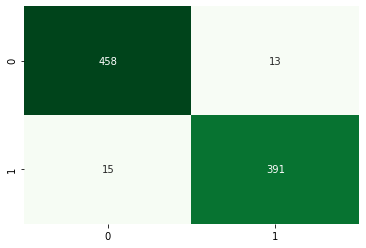

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d')

## Error Analysis

In [29]:
error_index = (y_test != y_pred)
y_test_error = y_test[error_index]
X_test_error = X_test[error_index]
prediction_error = y_pred[error_index]

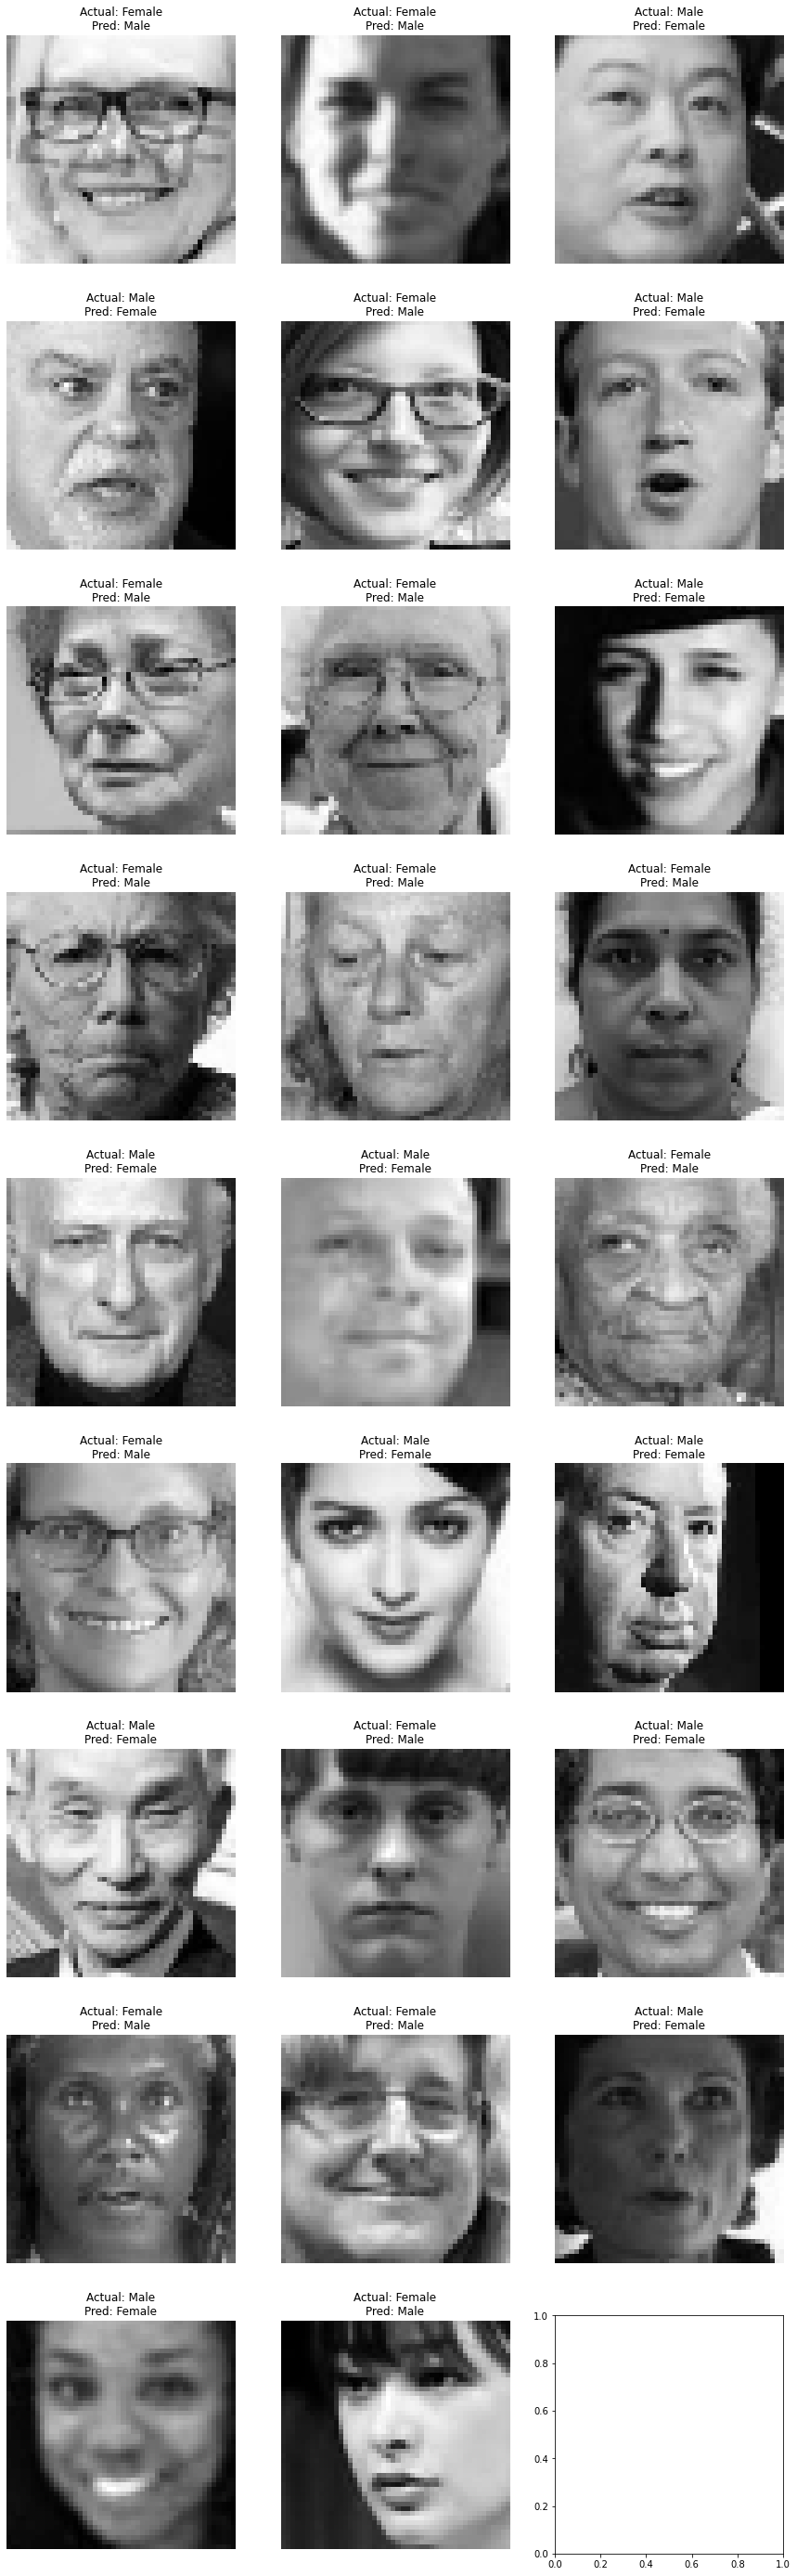

In [30]:
rows = int(np.floor(sum(error_index)/3)) #rows in subplots
cols = 3 #columns in subplots
x_samp = X_test_error
y_samp = y_test_error

fig,ax = plt.subplots(rows,cols,figsize=(15,50))
r = 0
c = 0
for i in range((rows*cols)-1):
    aa = x_samp[i].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    actual_lab = "Female" if y_samp.iloc[i] == 1 else "Male"
    pred_lab = "Female" if int(prediction_error[i]) == 1 else "Male"
    ax[r,c].set_title(f'Actual: {actual_lab}\nPred: {pred_lab}')
    c += 1
    if c == cols:
        c = 0
        r += 1
plt.show()